0:	learn: 219.3948950	test: 252.3513233	best: 252.3513233 (0)	total: 8.47ms	remaining: 4.23s
50:	learn: 82.7163900	test: 120.2532840	best: 120.2532840 (50)	total: 372ms	remaining: 3.27s
100:	learn: 60.9065662	test: 100.3365999	best: 100.3365999 (100)	total: 749ms	remaining: 2.96s
150:	learn: 52.2586232	test: 94.7995692	best: 94.7995692 (150)	total: 1.1s	remaining: 2.55s
200:	learn: 45.4874977	test: 93.0922270	best: 92.9601908 (188)	total: 1.46s	remaining: 2.16s
250:	learn: 40.4703671	test: 91.6488799	best: 91.6488799 (250)	total: 1.61s	remaining: 1.6s
300:	learn: 36.3589602	test: 90.8413744	best: 90.8413744 (300)	total: 1.77s	remaining: 1.17s
350:	learn: 33.0918095	test: 90.1008183	best: 89.9615516 (329)	total: 1.93s	remaining: 818ms
400:	learn: 29.4782832	test: 89.2314563	best: 89.2175490 (398)	total: 2.09s	remaining: 516ms
450:	learn: 26.5943651	test: 88.8496942	best: 88.8074798 (433)	total: 2.25s	remaining: 244ms
499:	learn: 24.2146295	test: 88.7178014	best: 88.6714924 (495)	total: 

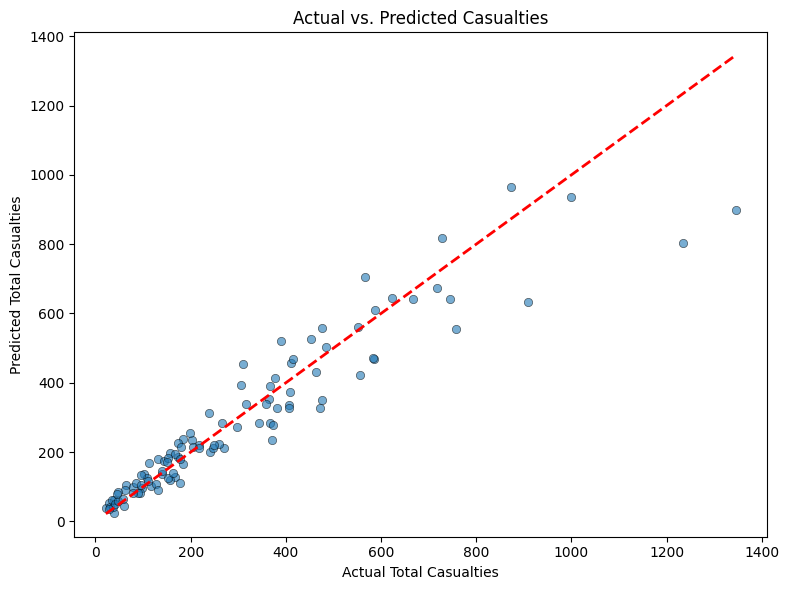

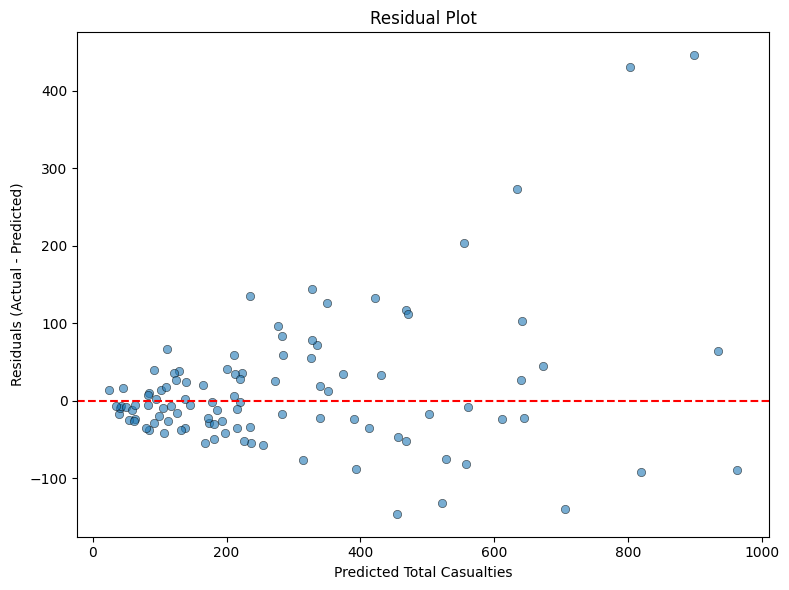

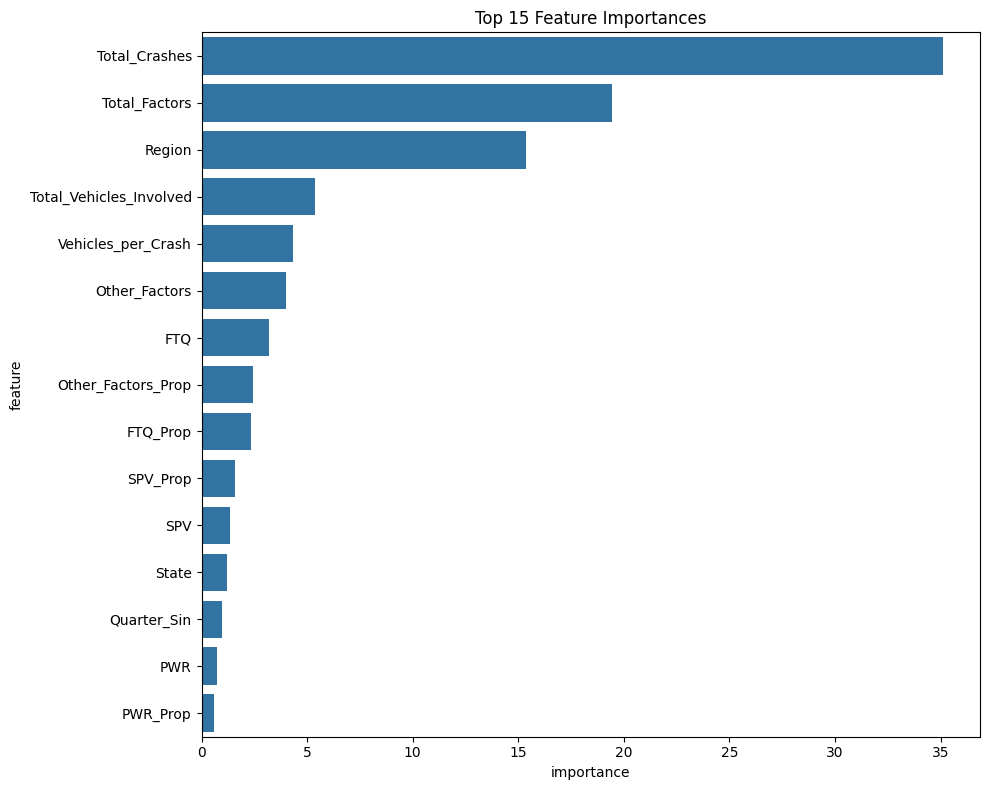

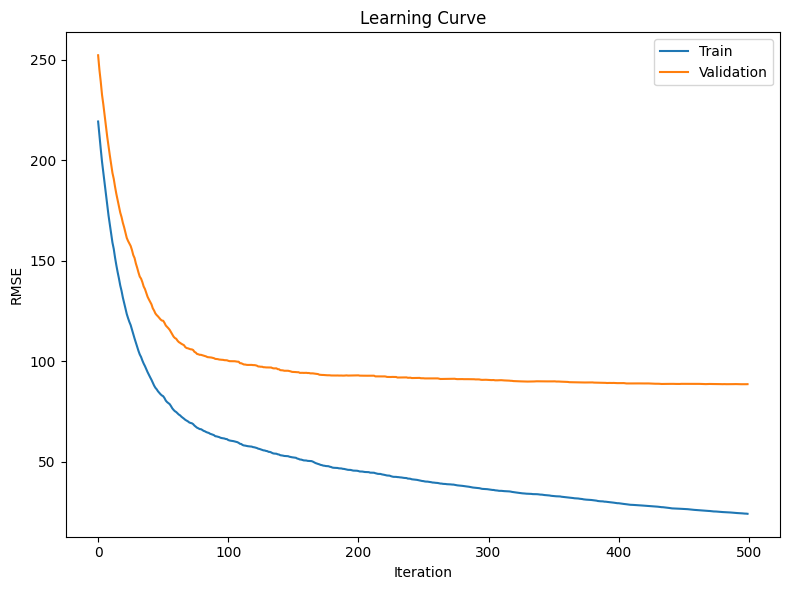

Train Score: 0.9854
Test Score: 0.8826


In [5]:
import warnings
warnings.filterwarnings('ignore')

# ================== 1. IMPORTS ==================
!pip install catboost
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ================== 2. LOAD DATA ==================
# Ensure the file 'Nigeria Crash Data P.csv' is in the current working directory
df = pd.read_csv('Nigeria Crash Data P.csv')

# ================== 3. DEFINE TARGET AND FEATURES ==================
target = 'Total_Casualties'

# Columns to drop (target‑related, redundant, or derived)
drop_cols = [
    'Num_Injured', 'Num_Killed',               # components of target
    'Casualty_Rate', 'Fatality_Rate',          # derived from target
    'Severe_Crash', 'High_Casualty',            # binary flags based on target
    'Quarter_Date',                             # redundant with Quarter_Num and Year
    'State_Encoded', 'Region_Encoded',          # encoded versions – we keep raw strings
]

# Drop all one‑hot encoded columns (start with 'State_' or 'Region_')
state_dummies = [col for col in df.columns if col.startswith('State_')]
region_dummies = [col for col in df.columns if col.startswith('Region_')]
drop_cols.extend(state_dummies + region_dummies)

# Drop the original 'Quarter' column if it exists
if 'Quarter' in df.columns:
    drop_cols.append('Quarter')

# The remaining columns will be used as features
feature_cols = [col for col in df.columns if col not in drop_cols + [target]]

# Separate features and target
X = df[feature_cols].copy()
y = df[target]

# Identify categorical columns
cat_features = ['State', 'Region']   # these are present in feature_cols

# ================== 4. TRAIN/TEST SPLIT ==================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================== 5. TRAIN CATBOOST REGRESSOR ==================
model = CatBoostRegressor(
    random_state=42,
    verbose=0,                      # silent training (use verbose=50 to see progress)
    cat_features=cat_features,
    iterations=500,
    learning_rate=0.05,
    depth=6,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=50                       # prints evaluation every 50 iterations
)

# ================== 6. EVALUATE ==================
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("MODEL PERFORMANCE ON TEST SET")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print("="*50)

# ================== 7. GRAPHICAL ANALYSIS ==================

# 7.1 Actual vs. Predicted scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Total Casualties')
plt.ylabel('Predicted Total Casualties')
plt.title('Actual vs. Predicted Casualties')
plt.tight_layout()
plt.show()

# 7.2 Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Total Casualties')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# 7.3 Feature importance (top 15)
feat_imp = pd.DataFrame({
    'feature': model.feature_names_,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# 7.4 Learning curve (optional, requires that evals_result was stored)
evals_result = model.get_evals_result()
if 'learn' in evals_result and 'validation' in evals_result:
    train_errors = evals_result['learn']['RMSE']
    valid_errors = evals_result['validation']['RMSE']
    plt.figure(figsize=(8,6))
    plt.plot(train_errors, label='Train')
    plt.plot(valid_errors, label='Validation')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Learning curve data not available.")


Train_Score = model.score(X_train, y_train)
Test_Score = model.score(X_test, y_test)
print(f"Train Score: {Train_Score:.4f}")
print(f"Test Score: {Test_Score:.4f}")